# Jack against the nationwide company

A a modification of the Jack's Car Rental problem.
One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to **shuttle one car to the second location for free**, while each additional car costs the usual $2\$$. Moreover, the nationwide car rental company has changed its policy on parking spaces: for each location now Jack can only park up to 10 vehicles free of charge. **If more than 10 cars are kept overnight at a location, then an additional cost of $4\$$ must be incurred** to use a second parking lot (independent of how many cars are kept there). The car rental company charges Jack with the additional parking lots price first thing in the morning, **before any possible moving of cars**.
In order to fulfill the exercise requirements, you need to **modify and solve** the new instance of the Jack's car rental problem with a **Value Iteration** algorithm.
Generate a subplot with six cells as the one seen in the "Tutorial Lecture" with the figures of 5 policies at different iterations: #0, #7, #14, #21, and the last (optimal!) one. In the sixth box plot the optimal value-function.
Use $\texttt{constant}$_$\texttt{returned}$_$\texttt{cars}$ = **True**.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson

In [2]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

SECOND_PARKING_LOT_REWARDS = 4

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
# Moving a negative number of cars means that we are moving them in the opposite direction (from II to I)

# An upper bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11
# This is done to save some computational time, since probability at this point is negligible

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()
# We will iteratively build a dictionary for the poisson random variable values, again to save computational time
# The constraint on lambda is only due to "bad" indexing

In [3]:
def poisson_probability(n, lam):
    global poisson_cache
    # Simple identifier if lam < 10
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

In [4]:
def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0
    
    ### my code add nonlinearity
    if action <= 0:
        returns -= MOVE_CAR_COST * abs(action)
    else:
        #1 free move
        returns -= MOVE_CAR_COST * abs(action - 1) 
        
    if state[0]> 10:
        returns -= SECOND_PARKING_LOT_REWARDS
    if state[1]>10:
        returns -= SECOND_PARKING_LOT_REWARDS
    
    
    # cost for moving cars
    #returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # We are computing an expectation in at least 2 dimensions, i.e. for each (meaningful) value we need to compute its probability!
    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

In [5]:
# This is the parameter of the function in the original code
constant_returned_cars = True

#1st step : Initialization of the value-function and policy
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# We start considering the simplest policy: for every possible state, no car is moved
# It makes sense: if is not clear what a meaningful action might be, better not to pay the cost of moving cars!
policy = np.zeros(value.shape, dtype=np.int)
iterations = 0
all_p = []

#2nd step
while True:    
    old_value = value.copy()
    # Sweep through all states following the same policy    
    plicy_copy = policy.copy()
    all_p.append(plicy_copy)
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            
            
            for action in actions:
                # if it is a 'legal' action, i.e. I am not trying to move more cars than I have in that location
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                else:
                    action_returns.append(-np.inf)
            new_action = actions[np.argmax(action_returns)]            
            policy[i, j] = new_action  
            
            new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
            # in-place update!
            value[i, j] = new_state_value
        max_value_change = abs(old_value - value).max()        
            
    #print(iterations)
    iterations += 1              
    print('max value change {}'.format(max_value_change))
    if max_value_change < 1e-4: 
        break


max value change 332.82747885856116
max value change 146.3593230770976
max value change 94.68460874706841
max value change 64.44184666442646
max value change 47.805070304782305
max value change 37.757889271744546
max value change 29.751744550829358
max value change 23.4975227371055
max value change 18.616705372675824
max value change 15.215401647366548
max value change 12.87797344082719
max value change 10.87265485707394
max value change 9.198158901471686
max value change 7.7758500605261816
max value change 6.569120286691771
max value change 5.547577195845008
max value change 4.683999209590411
max value change 3.957183831822306
max value change 3.4007029980228936
max value change 2.9120886629914366
max value change 2.4903915741087417
max value change 2.1286005831666444
max value change 1.8189155532475638
max value change 1.5541946277560328
max value change 1.3293508985943276
max value change 1.137186509239541
max value change 0.9728057167038742
max value change 0.8321770138878719
max v

In [29]:
len(all_p)

86

Text(0.5, 1.0, 'Plolicy 0')

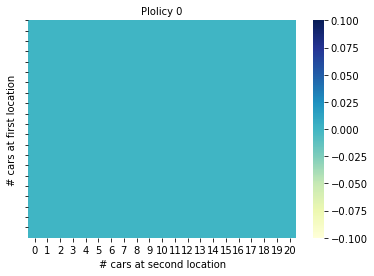

In [19]:
for i in range(len(all_p)):
    
fig = sns.heatmap(np.flipud(all_p[0]), cmap="YlGnBu")

fig.set_xlabel('# cars at second location', fontsize=10)
fig.set_ylabel('# cars at first location', fontsize=10)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_title('Plolicy 0', fontsize=10)


Text(0.5, 1.0, 'Plolicy 7')

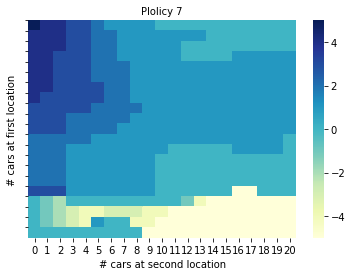

In [20]:
fig = sns.heatmap(np.flipud(all_p[7]), cmap="YlGnBu")

fig.set_xlabel('# cars at second location', fontsize=10)
fig.set_ylabel('# cars at first location', fontsize=10)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_title('Plolicy 7', fontsize=10)

Text(0.5, 1.0, 'Plolicy 14')

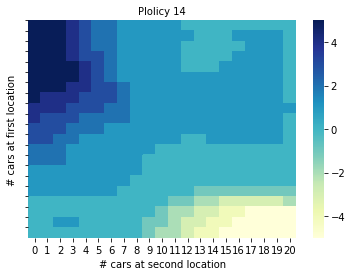

In [21]:
fig = sns.heatmap(np.flipud(all_p[14]), cmap="YlGnBu")

fig.set_xlabel('# cars at second location', fontsize=10)
fig.set_ylabel('# cars at first location', fontsize=10)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_title('Plolicy 14', fontsize=10)

Text(0.5, 1.0, 'Plolicy Optimal')

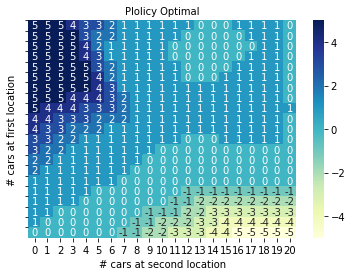

In [22]:
fig = sns.heatmap(np.flipud(all_p[85]), cmap="YlGnBu",annot = True)

fig.set_xlabel('# cars at second location', fontsize=10)
fig.set_ylabel('# cars at first location', fontsize=10)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_title('Plolicy Optimal', fontsize=10)
#fig.invert_yaxis()

Text(0.5, 1.0, 'Optimal Value')

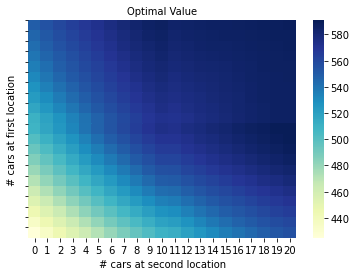

In [25]:
fig = sns.heatmap(np.flipud(value), cmap="YlGnBu")

fig.set_xlabel('# cars at second location', fontsize=10)
fig.set_ylabel('# cars at first location', fontsize=10)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_title('Optimal Value', fontsize=10)